A ideia desse notebook é gerar uma modelagem inicial, sem muita sofisticação e ajustes mais finos, não farei otimização de hiperparâmetros e nem calibragem das probabilidades dos modelos, por exemplo.

# General Imports

In [110]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay, RocCurveDisplay, confusion_matrix
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

from xgboost import XGBClassifier

# Separando conjunto de treino e teste

In [38]:
customer_churn = pd.read_csv("../data/final/customer_churn.csv")
customer_churn["Churn"] = customer_churn["Churn"].map({"Yes": 1,
                                                       "No": 0}) 
customer_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,custom_cluster
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.75,8672.45,0,0
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.65,8477.60,0,0
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,118.60,7990.05,0,0
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,118.60,7365.70,0,0
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),118.35,7804.15,1,0


In [39]:
X = customer_churn.drop(["customerID", "Churn"], axis=1)
y = customer_churn["Churn"]

In [40]:
# Mais uma vez, repetindo o exato split realizado no notebook de segmentação do cliente, há bastante dado para não utilizar validação cruzada.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5625, 20), (1407, 20), (5625,), (1407,))

In [41]:
categorical_columns = []
numerical_columns = ["tenure", "MonthlyCharges", "TotalCharges"]
for i in X_train.columns:
    if str(X_train[i].dtype) == "object":
        categorical_columns.append(i)

In [46]:
oh = OneHotEncoder(handle_unknown="ignore")
scaling = MinMaxScaler()
ct = ColumnTransformer([("oh", oh, categorical_columns), ("minmax", scaling, numerical_columns)],
                        remainder = "passthrough")


In [43]:
y_train.value_counts()

Churn
0    4130
1    1495
Name: count, dtype: int64

# Modelando

In [62]:
# instanciando modelos
weights_xgb = y_train.value_counts()[0]/y_train.value_counts()[1]

nb = Pipeline([("preprocess", ct),("estimator", CategoricalNB())])
knn = Pipeline([("preprocess", ct),("estimator", KNeighborsClassifier())])
lr = Pipeline([("preprocess", ct),("estimator", LogisticRegression(class_weight="balanced"))])
svm = Pipeline([("preprocess", ct),("estimator", SVC(class_weight="balanced", probability=True))])
dt = Pipeline([("preprocess", ct),("estimator", DecisionTreeClassifier(class_weight="balanced"))])
xgb = Pipeline([("preprocess", ct),("estimator", XGBClassifier(scale_pos_weight = weights_xgb))])
stk = Pipeline([("preprocess", ct),
                ("estimator", 
                 StackingClassifier([("nb", CategoricalNB()),
                                     ("knn", KNeighborsClassifier()),
                                     ("lr", LogisticRegression(class_weight="balanced")), 
                                     ("svm", SVC(class_weight="balanced", probability=True)), 
                                     ("dt", DecisionTreeClassifier(class_weight="balanced")), 
                                     ("xgb", XGBClassifier(scale_pos_weight = weights_xgb))], 
                                     final_estimator=LogisticRegression(class_weight="balanced"),
                                     n_jobs=6,
                                     cv = 10))])

In [63]:
models = [nb, knn, lr, svm, dt, xgb, stk]
models_name = ["Naive Bayes", "KNN","Logistic Regression", "SVM", "Decision Tree", "XGBoost", "Stack"]

for i, j in enumerate(models):
    j.fit(X_train, y_train)
    y_score_pred = j.predict_proba(X_test)

    avg_precision = np.round(average_precision_score(y_test, y_score_pred[:, 1]), 2)
    print(f"Average PR Score for model {models_name[i]}:", avg_precision)

Average PR Score for model Naive Bayes: 0.62
Average PR Score for model KNN: 0.53
Average PR Score for model Logistic Regression: 0.66
Average PR Score for model SVM: 0.59
Average PR Score for model Decision Tree: 0.41
Average PR Score for model XGBoost: 0.63
Average PR Score for model Stack: 0.67


Dessa forma, estarei utilizando o modelo Stack, pois em oportunidades futuras, ele poderá trazer uma melhor performance dado as muitas possibilidades de ajuste de hiperparâmetros.

In [90]:
# Treinando o modelo stack
stk.fit(X_train, y_train)
y_score_pred = stk.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_score_pred[:, 1])
ap = average_precision_score(y_test, y_score_pred[:, 1])

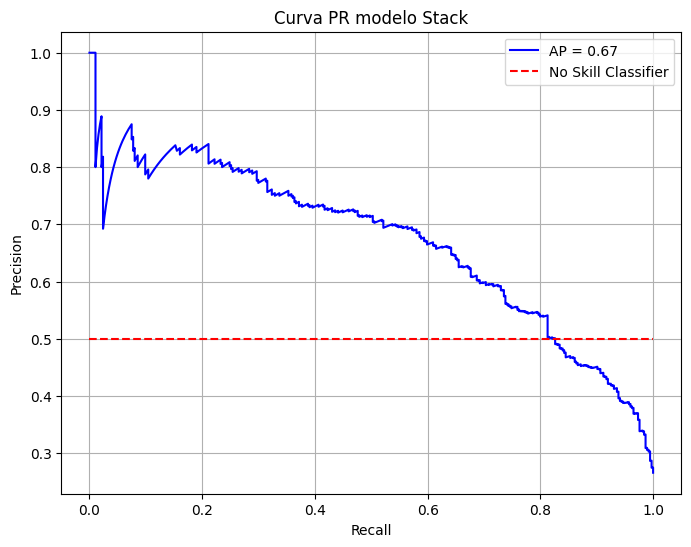

In [91]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'AP = {ap:.2f}')
plt.plot(np.linspace(0, 1, 20), [0.5 for i in range(0,20)], linestyle = "--", color= "r", label = "No Skill Classifier")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva PR modelo Stack')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
dict_pr = {
    "precision":precision[:-1],
    "recall":recall[:-1],
    "thresholds":thresholds
}

precision_recall_df = pd.DataFrame(dict_pr)
precision_recall_df["f1_score"] = 2*(precision_recall_df["precision"] * precision_recall_df["recall"])/(precision_recall_df["precision"] + precision_recall_df["recall"])

In [102]:
# Poderíamos escolher um threshold pelo f1 score, mas não é o que faremos.
precision_recall_df.sort_values("f1_score", ascending=False)

,precision,recall,thresholds,f1_score
945,0.592191,0.729947,0.594992,0.653892
944,0.590909,0.729947,0.594695,0.653110
947,0.592593,0.727273,0.596849,0.653061
950,0.594298,0.724599,0.598417,0.653012
943,0.589633,0.729947,0.593633,0.652330
...,...,...,...,...
1401,1.000000,0.010695,0.905538,0.021164
1400,0.800000,0.010695,0.905510,0.021108
1402,1.000000,0.008021,0.905656,0.015915
1403,1.000000,0.005348,0.906814,0.010638


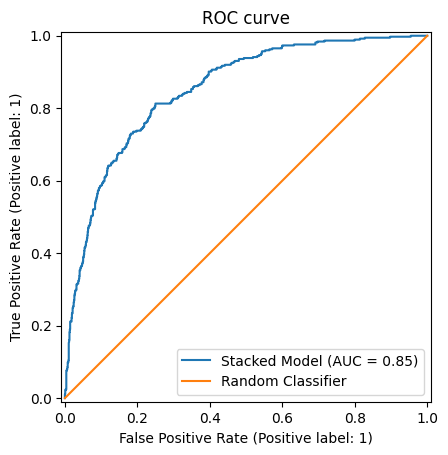

In [93]:
# Só fazendo um teste rápido do ROC-AUC, parece bom, mas como se trata de um problema de desbalanceamento de classe, realmente precisamos preferir pela Precision Recall
display = RocCurveDisplay.from_estimator(stk, X_test, y_test, name="Stacked Model")
_ = display.ax_.set_title("ROC curve")
plt.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), label="Random Classifier")
plt.legend();

# Matriz de Custo

O que foi feito até então era apenas uma forma de avaliar o modelo que utilizaríamos. Vamos imaginar como poderia vir a se tornar um cálculo de custo ou lucro médio por esse modelo escolhido e vamos basear nosso threshold para maximizar a métrica de lucro.

In [104]:
customer_churn["MonthlyCharges"].mean()

64.79820819112628

In [107]:
55*12 - 120

540

Obs.: Todos os valores utilizados a seguir referente à média de rentabilidade por cliente são meramente ilustrativos, excetuando pela média de cobrança mensal que obtive pelo meu dataset acima (65 reais -vou considerar em reais pra facilitar a comunicação-). 

Vamos supor que a estratégia de retenção de clientes que vão realizar churn seja de dar promoção no seu custo mensal por um período de 12 meses (o que é comum no Brasilaqui vou arbitrariamente supor 15% de desconto no serviço, o que implica num disconto de 10 reais aproximadamente no encargo mensal)
Dessa forma podemos montar uma matriz de custo com a seguinte estrutura:

- Verdadeiros Positivos(Quando eu prevejo que alguém vai churnear e realmente vai churnear) : (65 - 10)x12 de lucro - 10x12 reais de disconto de prejuízo, resultando em lucro de 540 reais(assumindo que esse disconto implique em perda de dinheiro)

- Verdadeiros Negativos (Quando prevejo que não haverá churn e o cliente realmente não realiza churn) : Como aqui não há estratégia de retenção sendo utilizada, isso não implica em nenhum lucro (0 reais).

- Falsos Positivos (Quando prevejo que haverá churn, mas não haverá) : Aqui realizamos a estratégia de retenção, mas acaba sendo em vão, então é só o custo associado ao disconto realizado (-10x12 = -120 reais)

- Falsos Negativos (Quando prevejo que não haverá churn, porém haverá) : Aqui não realizo estratégia de retenção quando deveria, daí perco 12 meses de receita (65 - 10)x12 = 660, aqui desconsidero o custo associado à promoção pois não estou efetivamente aplicando ela.


Uma forma de construir uma estimativa do custo de cada uma dessa situações, levando em consideração a performance do modelo seria:

Lucro esperado por consumidor $= p(p)*[TPR*b_{TP} + FNR*c_{FN}] + p(n)*[TNR*b_{TN} + FPR*c_{FP}]$

Onde:
- p(p) e p(n) são as probabilidades de observarmos as classes positivas e negativas respectivamente (aqui será usado apenas uma frequência percentual simples)
- TPR, FNR, TNR e FPR são a true positive rate, false negative rate, true negative rate e false positive rate respectivamente
- TP, FN, TN e FP são os true positives, false negatives, true negatives e false positives respectiviamente.
- b e c indicam o benefício e custo de cada um desses supracitados respectivamente de acordo com o índice.

Com os valores que supus, $b_{TP} = 540$, $c_{FN} = -660$, $b_{TN} = 0$ e $c_{FP} = -120$

In [109]:
y_train.value_counts(normalize=True)

Churn
0    0.734222
1    0.265778
Name: proportion, dtype: float64

Pela proporção retirada do conjunto de treina acima, $p(p) = 0.26$ e $p(n) = 0.74$, as taxas TPR, FNR, TNR e FPR dependerão do threshold escolhido pelo estimador. Para isso, montarei uma tabela contendo essas 4 variáveis para cada threshold do modelo stack e escolhei aquela que maximize o lucro esperado por consumidor.

In [123]:
tpr_list = []
fnr_list = []
tnr_list = []
fpr_list = []

thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    # Transformando probabilidades em previsões binárias com base no threshold
    y_pred = (y_score_pred[:, 1] > threshold).astype(int)
    
    # Calculando a matriz de confusão
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculando as métricas
    tpr = tp / (tp + fn)  # Taxa de verdadeiros positivos (True Positive Rate)
    fnr = fn / (tp + fn)  # Taxa de falsos negativos (False Negative Rate)
    tnr = tn / (tn + fp)  # Taxa de verdadeiros negativos (True Negative Rate)
    fpr = fp / (tn + fp)  # Taxa de falsos positivos (False Positive Rate)
    
    # Armazenando os valores nas listas
    tpr_list.append(tpr)
    fnr_list.append(fnr)
    tnr_list.append(tnr)
    fpr_list.append(fpr)

# Criando um DataFrame para armazenar os resultados
results_df = pd.DataFrame({
    'Threshold': thresholds,
    'TPR': tpr_list,
    'FNR': fnr_list,
    'TNR': tnr_list,
    'FPR': fpr_list
})

In [124]:
results_df["b_tp"] = 540
results_df["c_fn"] = -660
results_df["b_tn"] = 0
results_df["c_fp"] = -120
results_df["p_p"] = 0.26
results_df["p_n"] = 0.74

Agora calculando o lucro por consumidor esperado para cada threshold:

In [125]:
profit_from_positive = results_df["p_p"] * ((results_df["TPR"] * results_df["b_tp"]) + (results_df["FNR"] * results_df["c_fn"]))
profit_from_negative = results_df["p_n"] * ((results_df["TNR"] * results_df["b_tn"]) + (results_df["FPR"] * results_df["c_fp"]))
results_df["expected_profit"] = profit_from_positive + profit_from_negative

In [126]:
results_df.sort_values(by="expected_profit", ascending=False)

,Threshold,TPR,FNR,TNR,FPR,b_tp,c_fn,b_tn,c_fp,p_p,p_n,expected_profit
15,0.15,0.962567,0.037433,0.428848,0.571152,540,-660,0,-120,0.26,0.74,78.002559
16,0.16,0.957219,0.042781,0.447241,0.552759,540,-660,0,-120,0.26,0.74,77.967411
20,0.20,0.938503,0.061497,0.504356,0.495644,540,-660,0,-120,0.26,0.74,77.199669
21,0.21,0.935829,0.064171,0.512101,0.487899,540,-660,0,-120,0.26,0.74,77.053150
13,0.13,0.973262,0.026738,0.380445,0.619555,540,-660,0,-120,0.26,0.74,77.041297
...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.000000,1.000000,1.000000,0.000000,540,-660,0,-120,0.26,0.74,-171.600000
97,0.97,0.000000,1.000000,1.000000,0.000000,540,-660,0,-120,0.26,0.74,-171.600000
98,0.98,0.000000,1.000000,1.000000,0.000000,540,-660,0,-120,0.26,0.74,-171.600000
99,0.99,0.000000,1.000000,1.000000,0.000000,540,-660,0,-120,0.26,0.74,-171.600000


In [127]:
customer_churn.shape[0]*78

548496

Daqui vemos que o threshold que gera o maior lucro esperado é o 0.15, com 78 reais por consumidor aproximadamente, se pensarmos em toda nossa base (7032), teríamos um lucro de $78*7032 = 548.496$ de reais. Se comparássemos com um possível modelo que estivesse rodando (um que supusesse que ninguém precisa de estratégia de retenção, ou ainda, um modelo que supusesse que ninguém iria realizar churn - ou que todas as classes previstas fossem da classe majoritária-.), poderia-se observar o modelo de threshold = 1 para simular isso, ou seja que todos os dados fossem classificados como 0, teríamos um lucro esperado de -172 reais por pessoa.

Pode-se interpretar esse valor calculado como o valor que se espera perder ou ganhar por utilizar 1 modelo de previsão de churn, no melhor cenário apontei um lucro de 78 reais por pessoa e no pior, um modelo ingênuo, um prejuízo de 172 reais por pessoa. Isso é claro, desconsiderando qualquer lógica mais aprofundada de negócios ou outras variáveis. Essa estimativa pode ser livremente modificável, inclusive seus valores a depender do conhecimento específico da área interessada.